## JCP Surrodash Modelling Example Notebook

The following two blocks are used for loading the correct files and dependencies from the Github repo to be able to run the ML modelling code and plot the results.

In [1]:
#### ALL NOTEBOOK SHOULD HAVE SOME VERSION OF THIS #####################################
%load_ext autoreload
%autoreload 2
import os
import sys

currentdir = os.getcwd()
# go to root directory. change the # of os.path.dirnames based on where currentdir is
parentdir = os.path.dirname(os.path.dirname(currentdir)) 

# chek where I'm at. if I go too far up the tree, go back
if 'Protein-Purification-Model-Public' not in parentdir: parentdir = currentdir
if parentdir not in sys.path: sys.path.insert(0,parentdir)
########################################################################################

In [2]:
# importing py files from the Github repo

import utils 
import visualization.simple_data_vis as vis
import surrogate_models.nn_defs as engine
import tensorflow as tf

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


### Step 1: Load data and select your x and y.

In [3]:
# load data from just-private/data -- this is where we stash our hidden files due to the Just NDA
filename = 'mol_res_scan_results_7.csv' # this is the name of a data file produced from the mechanistic model
data = utils.load_data(parentdir, filename)

# select model inputs as X
x = [*data.columns[:2],*data.columns[4:]]

# purity and yield are y
y = data.columns[2:4]

### Step 2: Clean the data so that it can be fed properly to the models.

In [4]:
# Sometimes the MM produces data sets that contain rows with yield and purity higher than 1
# this isn't physically possible so we've removed these rows from the dataset
data = utils.preprocessing([data,], bounds = {'yield':[0,1],'purity':[0,1]})[0]

In [5]:
# Split data into train and test
train_x, test_x, train_y, test_y = utils.chroma_train_test_split(data, x, y)

In [6]:
# Standardize the inputs
train_x, test_x, scaler_x = utils.preprocessing(
    [train_x, test_x], 
    standarize = True, 
    skip = ['cut 1','cut 2']
    )

train = [train_x, train_y]
test = [test_x, test_y]

### Step 3: Define your models. 
Our code returns 4 models: a deterministic linear regression model, a probabilistic linear regression model, a deterministic NN, and a probabilistic NN.

In [7]:
# define models to test
dlr = engine.create_deterministic_linear_regressor(
    feature_names = x,
    target_names = y,
    name = 'DLR_'+filename[:-4]
)

plr = engine.create_probabilistic_linear_regressor(
    feature_names = x,
    target_names = y,
    name = 'PLR_'+filename[:-4],
)

dnn = engine.create_deterministic_nn(
    feature_names = x,
    target_names = y,
    hidden_units = [16,8,4],
    name = 'DNN_'+filename[:-4]
)

pnn = engine.create_probabilistic_nn(
    feature_names = x,
    target_names = y,
    hidden_units = [16,8,4,],
    name = 'PNN_'+filename[:-4],
)

models = [dlr,plr,dnn,pnn]

### Step 4: Train your models.

In [8]:
# train all the models under the same conditions
# the learning rate, number of epochs, and optimizer can all be changed if necessary

learning_rate = 0.01
epochs = 100
optimizer = 'Adam'
losses = ['mean_squared_error', engine.negative_loglikelihood]*2
loss_weights = (1/train_y.mean().div(train_y.mean().max())).round(2).to_dict()
histories = {}

for m,l in zip(models,losses):
    histories[utils.get_model_name(m,filename)] = engine.run_experiment(
        model = m, 
        loss = {y[0]:l,y[1]:l},
        loss_weights = loss_weights,
        optimizer = tf.keras.optimizers.Adam,
        learning_rate = learning_rate,
        num_epochs = epochs,
        train_dataset = train, 
        test_dataset = test,
        verbose = 0,
        log = 0
        )

settings = {'learning_rate' : learning_rate,
            'epochs' : epochs,
            'optimizer': optimizer,
            'loss_weights': loss_weights,
            'dataset' : filename}

Start training the model DLR_mol_res_scan_results_7 ...
Evaluating model performance...
Train MSE: 0.718
Test MSE: 0.763
Start training the model PLR_mol_res_scan_results_7 ...
Evaluating model performance...
Train MSE: 0.771
Test MSE: 0.861
Start training the model DNN_mol_res_scan_results_7 ...
Evaluating model performance...
Train MSE: 0.021
Test MSE: 0.028
Start training the model PNN_mol_res_scan_results_7 ...
Evaluating model performance...
Train MSE: 0.013
Test MSE: 0.022


### Step 6: Check your model prediction accuracy.
The model predicts both yield and purity; note that yield is represented by circles and purity is represented by triangles in the below plots. The red data is from the test set and the black data is from the training set. The most accurate models will have data aligning on the x=y line plotted in light grey in each figure.

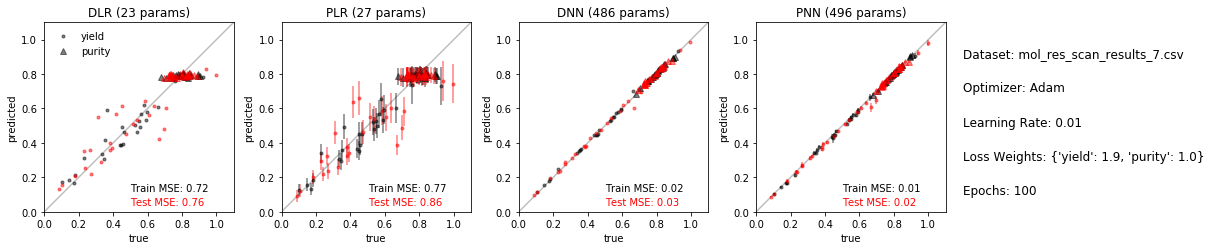

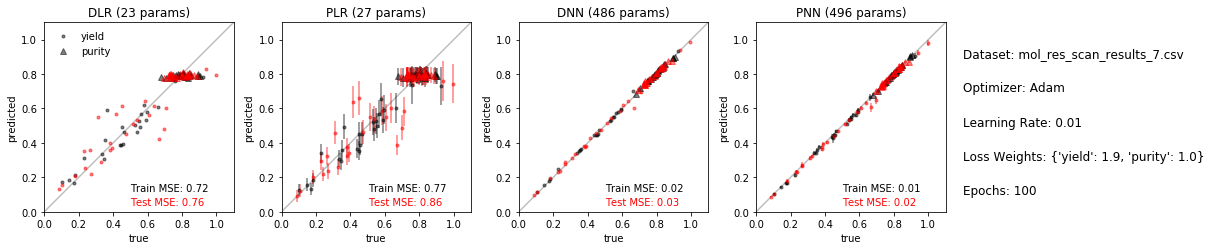

In [9]:
# check the accuracy of your model predictions
vis.scatter_hats(models, train, test, settings, n_points = 25)

### Step 7: Check your training process.

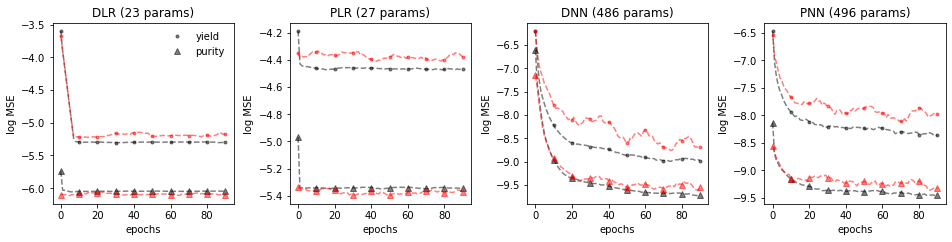

In [11]:
# check training process (note: these are metrics not losses)
vis.training_curves(models, y, settings, histories, smoothing = int(settings['epochs']*0.1))

### Step 8: Use or modify your models.
You can choose to modify the models by editing the learning rate/epochs/optimizer or by editing the structure in the dab_nn_defs.py file. Once you're comfortable with the predictive power of your models, you can use them to predict yield and purity from the input parameters.